In [1]:
import colorsys
import os
import datetime
import numpy as np
import yaml
from PIL import Image, ImageFont, ImageDraw
from IPython.display import SVG
import matplotlib.pyplot as plt
from timeit import default_timer as timer
#---
# Root directory of the project
# ROOT_DIR = os.path.abspath("../../")
os.chdir('/home/gustavo/workspace/mestrado/grv-keras-yolo3')
#---
import tensorflow as tf
from keras.backend.tensorflow_backend import set_session
config = tf.ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 0.3
set_session(tf.Session(config=config))
#---
from keras import backend as K
from keras.models import load_model
from keras.layers import Input
from keras.utils import multi_gpu_model
#---
from yolo3.model import yolo_eval, yolo_body, tiny_yolo_body, tiny_yolo_infusion_body
from yolo3.utils import letterbox_image
#---
%matplotlib inline

Using TensorFlow backend.


Set config

In [2]:
#general config

##seg
# config_path='grv/pytrains/train-11-config.yml'
# weights_path = '/home/gustavo/Desktop/keras-yolo3_weigths/seg_ep050-loss-1096.604-val_loss-1100.870.h5'
##default
config_path='grv/pytrains/train-12-config.yml'
weights_path = '/home/gustavo/Desktop/keras-yolo3_weigths/default_ep038-loss11.005-val_loss10.724.h5'

train_config = None
with open(config_path, 'r') as stream:
    train_config = yaml.load(stream)
print(train_config)

{'model_name': 'default_tiny_yolo', 'train_path': 'train_pti01_6342imgs_v20180706193526_keras.txt', 'test_path': 'test_pti01_1585imgs_v20180706193526_keras.txt', 'log_dir': 'logs/default-tiny-scratch-000/', 'classes_path': 'model_data/pti_classes.txt', 'anchors_path': 'model_data/tiny_yolo_anchors.txt'}


Class Model

In [3]:
class YOLO(object):
    def __init__(self):
        self.model_name = train_config['model_name']
        # self.model_path = 'model_data/yolo.h5' # model path or trained weights path
        # self.model_path = 'logs/000_5epochs/trained_weights_final.h5'
        if not weights_path:
            self.model_path = os.path.join(train_config['log_dir'] , 'trained_weights_final.h5')
        else:
            self.model_path = weights_path

        # self.anchors_path = 'model_data/yolo_anchors.txt'
        self.classes_path = train_config['classes_path']
        # self.classes_path = 'model_data/coco_classes.txt'
        self.anchors_path = train_config['anchors_path']
        self.score = 0.3
        self.iou = 0.45
        self.class_names = self._get_class()
        self.anchors = self._get_anchors()
        self.sess = K.get_session()
        self.model_image_size = (416, 416) # fixed size or (None, None), hw
        self.boxes, self.scores, self.classes = self.generate()

    def _get_class(self):
        classes_path = os.path.expanduser(self.classes_path)
        with open(classes_path) as f:
            class_names = f.readlines()
        class_names = [c.strip() for c in class_names]
        return class_names

    def _get_anchors(self):
        anchors_path = os.path.expanduser(self.anchors_path)
        with open(anchors_path) as f:
            anchors = f.readline()
        anchors = [float(x) for x in anchors.split(',')]
        return np.array(anchors).reshape(-1, 2)

    def generate(self):
        model_path = os.path.expanduser(self.model_path)
        assert model_path.endswith('.h5'), 'Keras model or weights must be a .h5 file.'

        # Load model, or construct model and load weights.
        num_anchors = len(self.anchors)
        num_classes = len(self.class_names)
        is_tiny_version = num_anchors==6 # default setting
        if self.model_name == 'tiny_yolo_infusion':
            self.yolo_model = tiny_yolo_infusion_body(Input(shape=(None,None,3)), num_anchors//2, num_classes)
            self.yolo_model.load_weights(self.model_path)
        else:
            try:
                self.yolo_model = load_model(model_path, compile=False)
            except:
                self.yolo_model = tiny_yolo_body(Input(shape=(None,None,3)), num_anchors//2, num_classes) \
                    if is_tiny_version else yolo_body(Input(shape=(None,None,3)), num_anchors//3, num_classes)
                self.yolo_model.load_weights(self.model_path) # make sure model, anchors and classes match
            else:
                assert self.yolo_model.layers[-1].output_shape[-1] == \
                    num_anchors/len(self.yolo_model.output) * (num_classes + 5), \
                    'Mismatch between model and given anchor and class sizes'

        print('{} model, anchors, and classes loaded.'.format(model_path))

        # Generate colors for drawing bounding boxes.
        hsv_tuples = [(x / len(self.class_names), 1., 1.)
                      for x in range(len(self.class_names))]
        self.colors = list(map(lambda x: colorsys.hsv_to_rgb(*x), hsv_tuples))
        self.colors = list(
            map(lambda x: (int(x[0] * 255), int(x[1] * 255), int(x[2] * 255)),
                self.colors))
        np.random.seed(10101)  # Fixed seed for consistent colors across runs.
        np.random.shuffle(self.colors)  # Shuffle colors to decorrelate adjacent classes.
        np.random.seed(None)  # Reset seed to default.

        # Generate output tensor targets for filtered bounding boxes.
        self.input_image_shape = K.placeholder(shape=(2, ))
        boxes, scores, classes = yolo_eval(self.yolo_model.output, self.anchors,
                len(self.class_names), self.input_image_shape,
                score_threshold=self.score, iou_threshold=self.iou, model_name=self.model_name)

        return boxes, scores, classes

    def detect_image(self, image, verbose=False, draw=False, output_file=None):
        start = timer()

        if self.model_image_size != (None, None):
            assert self.model_image_size[0]%32 == 0, 'Multiples of 32 required'
            assert self.model_image_size[1]%32 == 0, 'Multiples of 32 required'
            boxed_image = letterbox_image(image, tuple(reversed(self.model_image_size)))
        else:
            new_image_size = (image.width - (image.width % 32),
                              image.height - (image.height % 32))
            boxed_image = letterbox_image(image, new_image_size)
        image_data = np.array(boxed_image, dtype='float32')

        # print(image_data.shape)
        image_data /= 255.
        image_data = np.expand_dims(image_data, 0)  # Add batch dimension.

        out_boxes, out_scores, out_classes = self.sess.run(
            [self.boxes, self.scores, self.classes],
            feed_dict={
                self.yolo_model.input: image_data,
                self.input_image_shape: [image.size[1], image.size[0]],
                K.learning_phase(): 0
            })

        if verbose:
            print('Found {} boxes for {}'.format(len(out_boxes), 'img'))

        if draw:
            font = ImageFont.truetype(font='font/FiraMono-Medium.otf',
                        size=np.floor(3e-2 * image.size[1] + 0.5).astype('int32'))
            thickness = (image.size[0] + image.size[1]) // 300

        detections_string = ''
        for i, c in reversed(list(enumerate(out_classes))):
            predicted_class = self.class_names[c]
            box = out_boxes[i]
            score = out_scores[i]

            if draw:
                label = '{} {:.2f}'.format(predicted_class, score)
                imdraw = ImageDraw.Draw(image)
                label_size = imdraw.textsize(label, font)

            top, left, bottom, right = box
            top = max(0, np.floor(top + 0.5).astype('int32'))
            left = max(0, np.floor(left + 0.5).astype('int32'))
            bottom = min(image.size[1], np.floor(bottom + 0.5).astype('int32'))
            right = min(image.size[0], np.floor(right + 0.5).astype('int32'))
            if verbose:
                print(label, (left, top), (right, bottom))

            if draw:
                if top - label_size[1] >= 0:
                    text_origin = np.array([left, top - label_size[1]])
                else:
                    text_origin = np.array([left, top + 1])

                    # My kingdom for a good redistributable image drawing library.
                for i in range(thickness):
                    imdraw.rectangle(
                        [left + i, top + i, right - i, bottom - i],
                        outline=self.colors[c])
                imdraw.rectangle(
                    [tuple(text_origin), tuple(text_origin + label_size)],
                    fill=self.colors[c])
                imdraw.text(text_origin, label, fill=(0, 0, 0), font=font)
                del imdraw

            # <left> <top> <right> <bottom> <class_id> <confidence>
            detections_string += ' {},{},{},{},{},{}'.format(left, top, right, bottom, c, score)

        end = timer()
        if verbose:
            print('Executed in: ', end - start)

        '''
        img_path x_min,y_min,x_max,y_max,obj_score
        path/to/img1.jpg 50,100,150,200,0 30,50,200,120,3
        path/to/img2.jpg 120,300,250,600,2
        '''
#         output_file.write('{}{}\n'.format(image.filename, detections_string))

        return image

    def close_session(self):
        self.sess.close()



In [4]:
#Run
yolo = YOLO()

/home/gustavo/Desktop/keras-yolo3_weigths/default_ep038-loss11.005-val_loss10.724.h5 model, anchors, and classes loaded.


In [5]:
yolo.yolo_model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, None, None, 3 0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, None, None, 1 432         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, None, None, 1 64          conv2d_1[0][0]                   
__________________________________________________________________________________________________
leaky_re_lu_1 (LeakyReLU)       (None, None, None, 1 0           batch_normalization_1[0][0]      
__________________________________________________________________________________________________
max_poolin

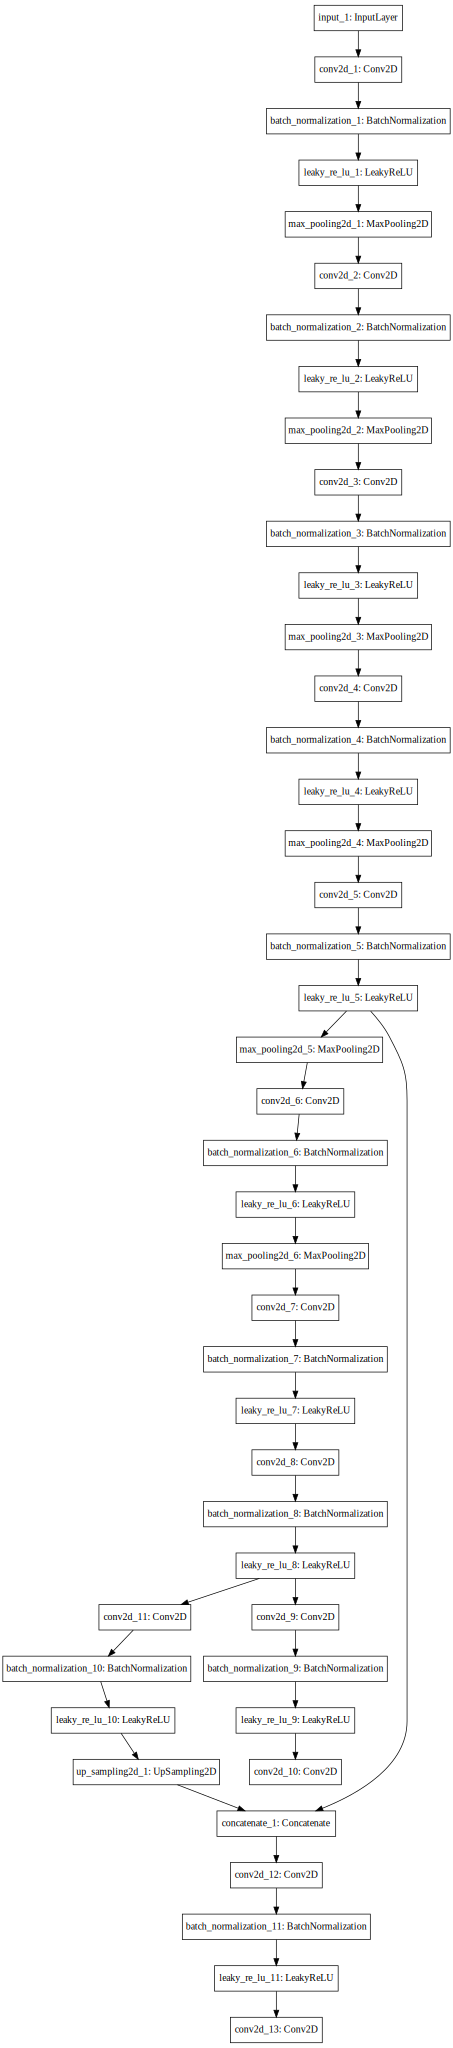

In [6]:
from keras.utils.vis_utils import model_to_dot
SVG(model_to_dot(yolo.yolo_model).create(prog='dot', format='svg'))

In [7]:
def layer_to_visualize(layer,model,img_to_visualize, seg=False, grid_side_limit=4):
    inputs = [K.learning_phase()] + model.inputs

    _convout1_f = K.function(inputs, [layer.output])
    def convout1_f(X):
        # The [0] is to disable the training phase flag
        return _convout1_f([0] + [X])
    img_to_visualize_expanded = np.expand_dims(img_to_visualize, axis=0)
    convolutions = convout1_f(img_to_visualize_expanded)
    convolutions = np.squeeze(convolutions)

    print('Shape of layer (w,h,filters):', convolutions.shape)
    if seg:
        fig = plt.figure(figsize=(16, 8), dpi=80)
        ax = fig.add_subplot(1,3,1)
        plt.gca().set_title('image')
        ax.imshow(img_to_visualize)
        ax = fig.add_subplot(1,3,2)
        plt.gca().set_title('foreground')
        ax.imshow(convolutions[:,:,0],cmap='jet')
        ax = fig.add_subplot(1,3,3)
        plt.gca().set_title('background')
        ax.imshow(convolutions[:,:,1],cmap='jet',)
    else:
        n = convolutions.shape[2]
        n = int(np.ceil(np.sqrt(n)))
        if n > grid_side_limit:
            n = grid_side_limit
            print("This plot is being limited to a maximum of {} filters".format(n*n))
            
        fig = plt.figure(figsize=(16, 8), dpi=80)
        # we use the first slot to display the original image.
        ax = fig.add_subplot(n,n,1)
        plt.gca().set_title('original')
        
        ax.imshow(img_to_visualize)
        for i in range(len(convolutions[0,0,:n*n])):
            if i == 0:
                # we have spent the first position to the original image.
                continue
            ax = fig.add_subplot(n,n,i+1)
            ax.imshow(convolutions[:,:,i], cmap='jet')

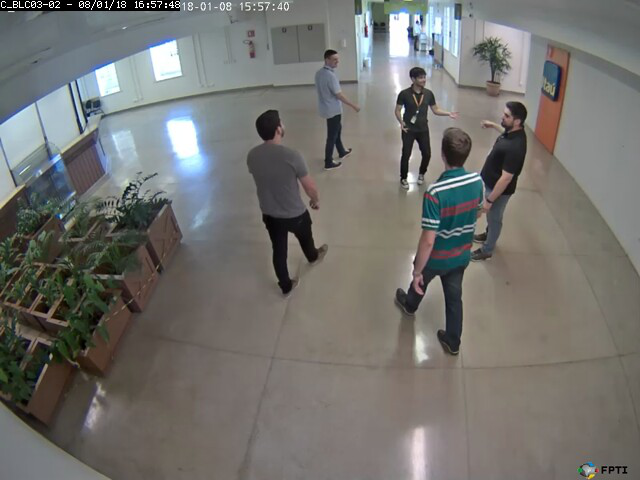

In [8]:
img_path = '/home/gustavo/workspace/datasets/pti/PTI01/C_BLC03-02/0/18/01/08/16/57/18/00150-capture.jpg'
img_to_visualize = Image.open(img_path)
display(img_to_visualize) 

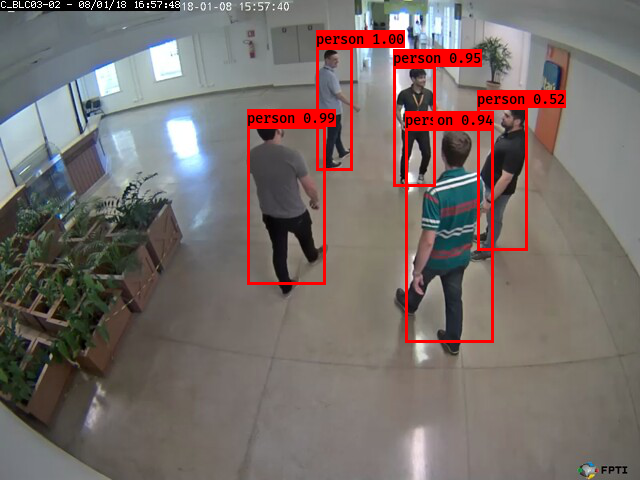

In [9]:
r_image = yolo.detect_image(img_to_visualize.copy(), draw=True)
display(r_image)

conv2d_1
Shape of layer (w,h,filters): (480, 640, 16)


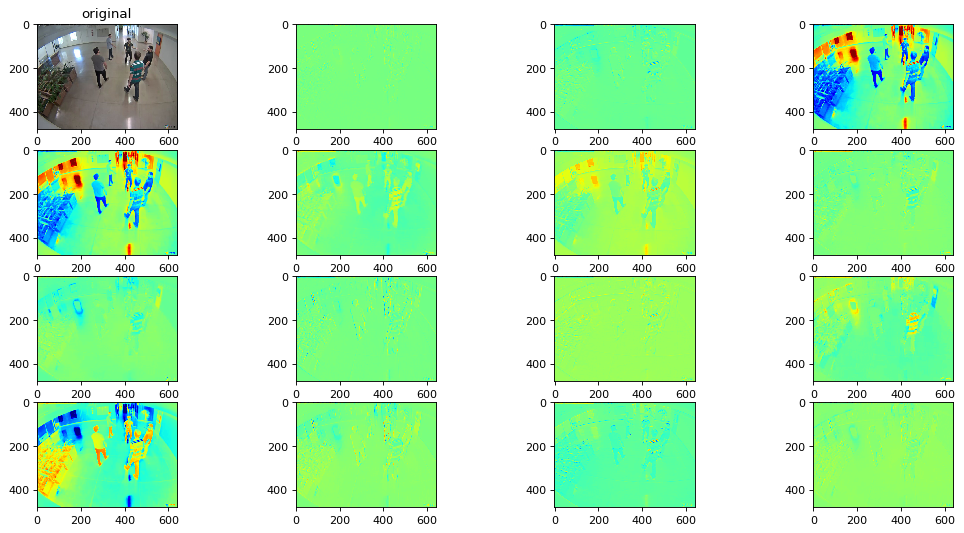

In [10]:
target_layer = yolo.yolo_model.get_layer(name='conv2d_1')
print(target_layer.name)
layer_to_visualize(target_layer, model=yolo.yolo_model,img_to_visualize=img_to_visualize)

conv2d_2
Shape of layer (w,h,filters): (240, 320, 32)
This plot is being limited to a maximum of 16 filters


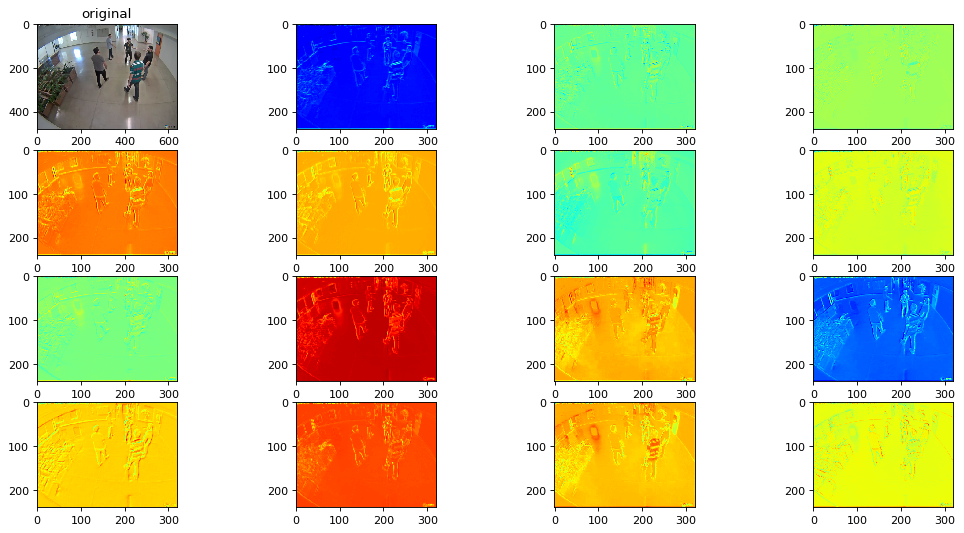

In [11]:
target_layer = yolo.yolo_model.get_layer(name='conv2d_2')
print(target_layer.name)
layer_to_visualize(target_layer, model=yolo.yolo_model,img_to_visualize=img_to_visualize)

conv2d_3
Shape of layer (w,h,filters): (120, 160, 64)
This plot is being limited to a maximum of 16 filters


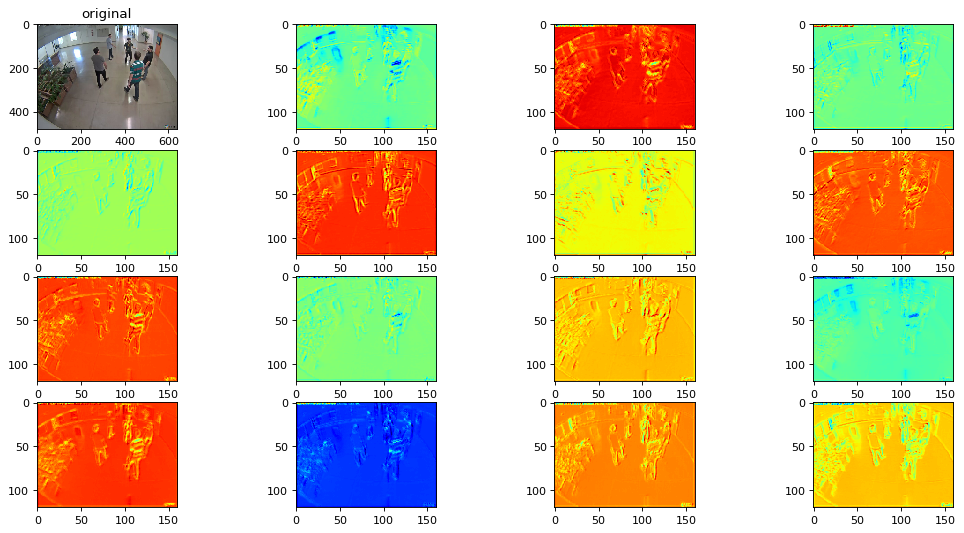

In [12]:
target_layer = yolo.yolo_model.get_layer(name='conv2d_3')
print(target_layer.name)
layer_to_visualize(target_layer, model=yolo.yolo_model,img_to_visualize=img_to_visualize)

### The last layer of the tiny-yolo backbone.

This is a relu layer. Should we use this one as the last layer?

leaky_re_lu_5
Shape of layer (w,h,filters): (30, 40, 256)
This plot is being limited to a maximum of 16 filters


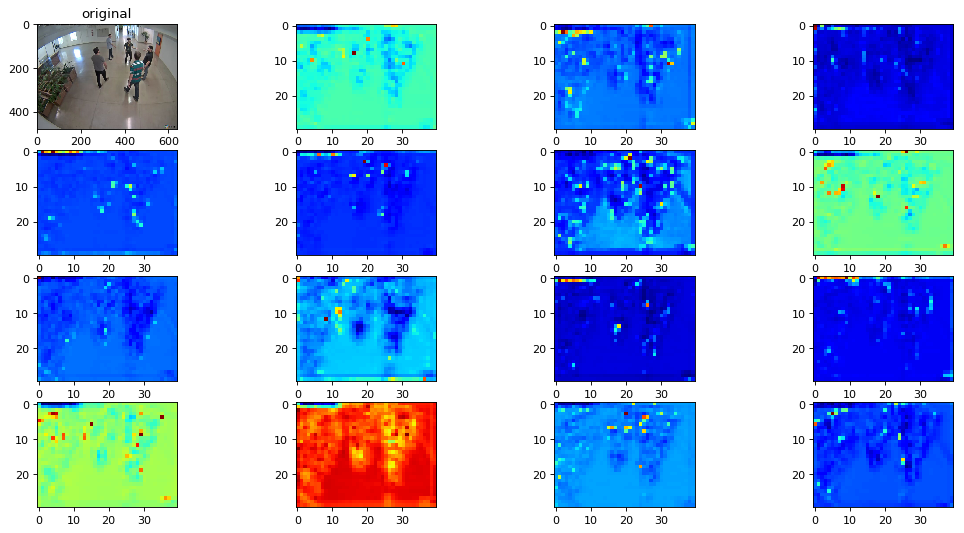

In [13]:
target_layer = yolo.yolo_model.get_layer(name='leaky_re_lu_5')
print(target_layer.name)
layer_to_visualize(target_layer, model=yolo.yolo_model,img_to_visualize=img_to_visualize)

### A layer before the last one from the backbone. With batch_normalization and without relu.

batch_normalization_5
Shape of layer (w,h,filters): (30, 40, 256)
This plot is being limited to a maximum of 16 filters


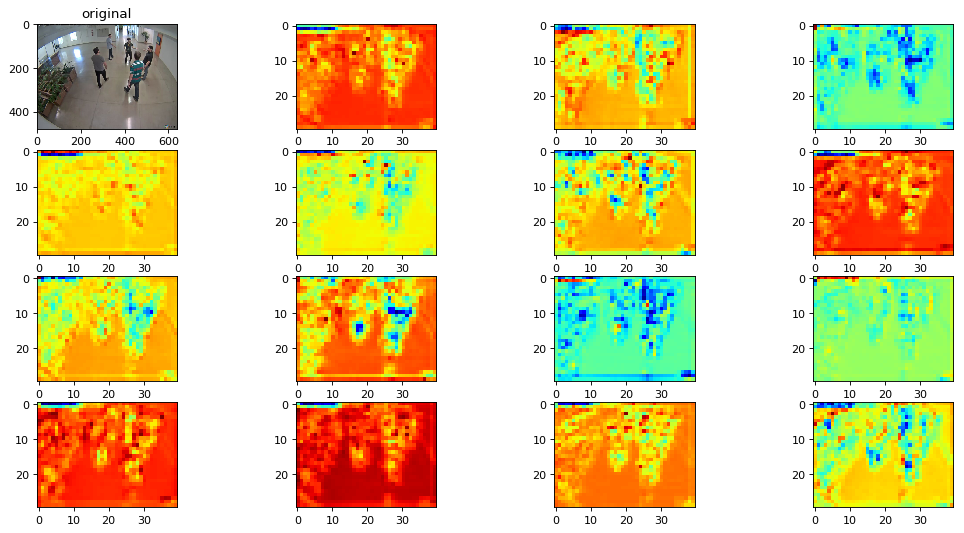

In [14]:
target_layer = yolo.yolo_model.get_layer(name='batch_normalization_5')
print(target_layer.name)
layer_to_visualize(target_layer, model=yolo.yolo_model,img_to_visualize=img_to_visualize)

### A two layers before the end of the backbone. Without the relu and batch norm. This is a conv.

Seems like the batch norm layer after this one does not change the overall output.

conv2d_5
Shape of layer (w,h,filters): (30, 40, 256)
This plot is being limited to a maximum of 16 filters


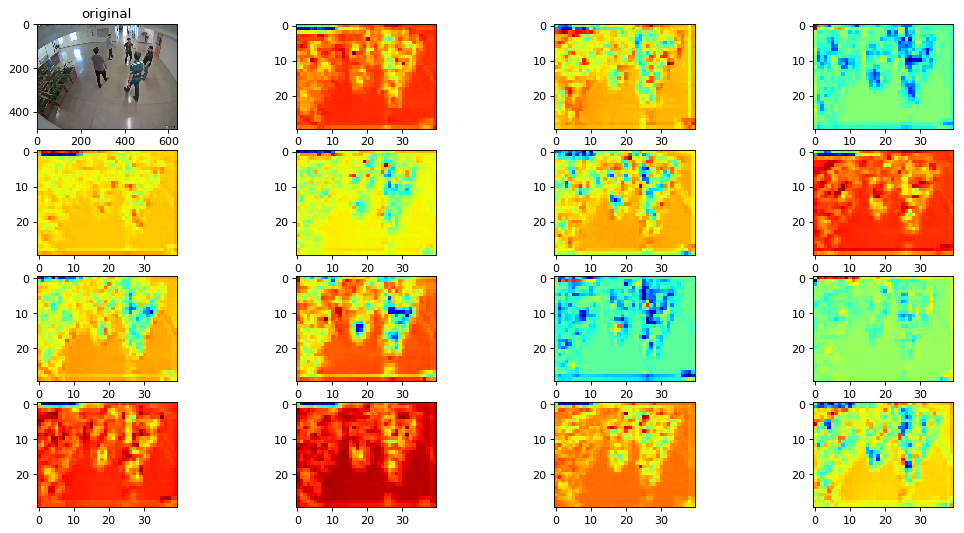

In [15]:
target_layer = yolo.yolo_model.get_layer(name='conv2d_5')
print(target_layer.name)
layer_to_visualize(target_layer, model=yolo.yolo_model,img_to_visualize=img_to_visualize)

yolo_head_a_output

conv2d_10
Shape of layer (w,h,filters): (15, 20, 18)
This plot is being limited to a maximum of 16 filters


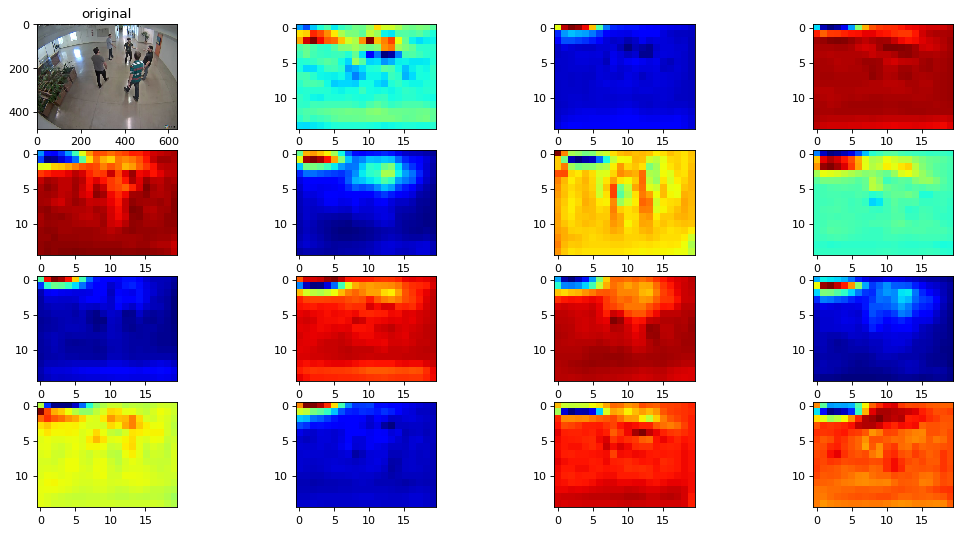

In [16]:
target_layer = yolo.yolo_model.get_layer(name='conv2d_10')
print(target_layer.name)
layer_to_visualize(target_layer, model=yolo.yolo_model,img_to_visualize=img_to_visualize)

yolo_head_b_output

conv2d_13
Shape of layer (w,h,filters): (30, 40, 18)
This plot is being limited to a maximum of 16 filters


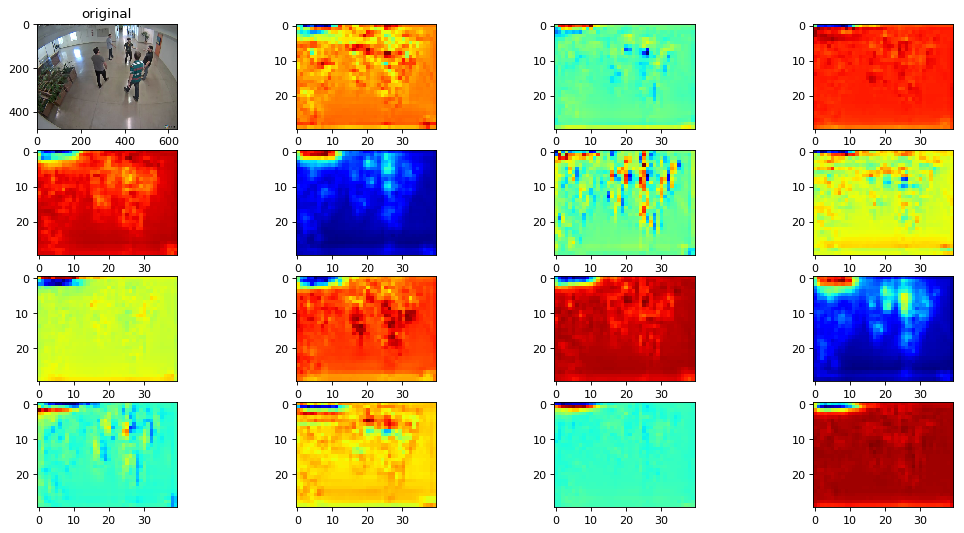

In [17]:
target_layer = yolo.yolo_model.get_layer(name='conv2d_13')
print(target_layer.name)
layer_to_visualize(target_layer, model=yolo.yolo_model,img_to_visualize=img_to_visualize)

In [33]:
#keras-vis imports -> library to visualize some network info.
from vis.visualization import visualize_saliency
from vis.utils import utils
from keras import activations

In [37]:
last_layer_index = len(yolo.yolo_model.layers)-1
print('last layer name:',yolo.yolo_model.layers[last_layer_index].name)

last layer name: conv2d_13


In [42]:
def get_layer_idx_by_name(target_layer_name):
    for idx, layer in enumerate(yolo.yolo_model.layers):
        if layer.name == target_layer_name:
            return idx

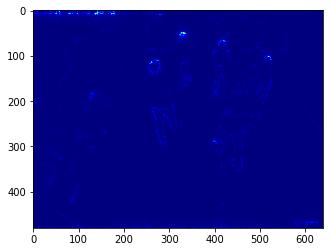

In [40]:
img_to_visualize_expanded = np.expand_dims(img_to_visualize, axis=0)
grads = visualize_saliency(yolo.yolo_model, last_layer_index, filter_indices=None, seed_input=img_to_visualize_expanded, backprop_modifier='guided')
# Plot with 'jet' colormap to visualize as a heatmap.
plt.imshow(grads, cmap='jet')

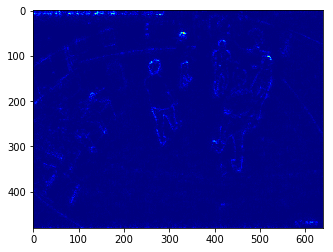

In [43]:
img_to_visualize_expanded = np.expand_dims(img_to_visualize, axis=0)
grads = visualize_saliency(yolo.yolo_model, get_layer_idx_by_name('conv2d_5'), filter_indices=None, seed_input=img_to_visualize_expanded, backprop_modifier='guided')
# Plot with 'jet' colormap to visualize as a heatmap.
plt.imshow(grads, cmap='jet')